## 물고기 분류기

In [28]:
import numpy as np
import os
import PIL
import PIL.Image
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pathlib

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
data_dir = pathlib.Path('./dataset')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

323


In [4]:
batch_size = 32
img_height = 228
img_width = 228

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
#   image_size=(img_height, img_width),
  batch_size=batch_size)

Found 396 files belonging to 6 classes.
Using 317 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
#   image_size=(img_height, img_width),
  batch_size=batch_size)

Found 396 files belonging to 6 classes.
Using 79 files for validation.


이러한 데이터세트의 `class_names` 속성에서 클래스 이름을 찾을 수 있습니다.

In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['catfish_메기', 'crucian carp_붕어', 'flatfish_광어', 'golden mandarin fish_쏘가리', 'red snapper_참돔', 'rockfish_우럭']


### 데이터 시각화하기

훈련 데이터세트의 처음 9개 이미지는 다음과 같습니다.

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

이러한 데이터세트를 사용하는 모델을 `model.fit`(이 튜토리얼의 뒷부분에 표시)에 전달하여 모델을 훈련할 수 있습니다. 원하는 경우, 데이터세트를 수동으로 반복하고 이미지 배치를 검색할 수도 있습니다.

In [ ]:
# data_augmentation = tf.keras.Sequential(
#     [
#         tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
#         tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
#     ]
# )

In [ ]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(2):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


`image_batch`는 형상 `(32, 180, 180, 3)`의 텐서입니다. 이것은 형상 `180x180x3`의 32개 이미지 배치입니다(마지막 치수는 색상 채널 RGB를 나타냄). `label_batch`는 형상 `(32,)`의 텐서이며 32개 이미지에 해당하는 레이블입니다.


참고: 이들 텐서 중 하나에서 `.numpy()`를 호출하여 `numpy.ndarray`로 변환할 수 있습니다.

### 데이터 표준화하기


RGB 채널 값은 `[0, 255]` 범위에 있습니다. 신경망에는 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다. 여기서는 Rescaling 레이어를 사용하여 값이 `[0, 1]`에 있도록 표준화합니다.

In [9]:
IMG_SIZE = 250

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

이 레이어를 사용하는 방법에는 두 가지가 있습니다. map을 호출하여 데이터세트에 레이어를 적용할 수 있습니다.

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.1),
])

또는 모델 정의 내에 레이어를 포함하여 배포를 단순화할 수 있습니다. 여기서는 두 번째 접근 방식을 사용할 것입니다.

참고: 픽셀 값을 `[-1,1]`으로 조정하려면 대신 `Rescaling(1./127.5, offset=-1)`를 작성할 수 있습니다.

참고: 이전에 `image_dataset_from_directory`의 `image_size` 인수를 사용하여 이미지 크기를 조정했습니다. 모델에 크기 조정 논리를 포함하려면 [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) 레이어를 대신 사용할 수 있습니다.


### 성능을 위한 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O가 차단되지 않고 디스크에서 데이터를 생성할 수 있도록 합니다. 데이터를 로드할 때 사용해야 하는 두 가지 중요한 메서드입니다.

`.cache()`는 첫 번째 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.

`.prefetch()`는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

관심 있는 독자는 [데이터 성능 가이드](https://www.tensorflow.org/guide/data_performance#prefetching)에서 두 가지 메서드와 디스크에 데이터를 캐시하는 방법에 대해 자세히 알아볼 수 있습니다.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 모델 훈련하기

완전성을 위해 준비한 데이터세트를 사용하여 간단한 모델을 훈련하는 방법을 보여줍니다. 이 모델은 어떤 식으로든 조정되지 않았습니다. 목표는 방금 만든 데이터세트를 사용하여 역학을 보여주는 것입니다. 이미지 분류에 대한 자세한 내용은 이 [튜토리얼](https://www.tensorflow.org/tutorials/images/classification)을 참조하세요.

In [15]:
model = tf.keras.Sequential([
    resize_and_rescale,
#     data_augmentation,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

참고: 몇 가지 epoch에 대해서만 훈련하므로 이 튜토리얼은 빠르게 진행됩니다. 

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)
hdf5_file = "./model/test.hdf5"
model.save_weights(hdf5_file)

Epoch 1/20
10/10 [==============================] - 5s 296ms/step - loss: 4.0779 - accuracy: 0.2021 - val_loss: 1.8320 - val_accuracy: 0.1772
Epoch 2/20
10/10 [==============================] - 1s 100ms/step - loss: 1.7540 - accuracy: 0.2456 - val_loss: 1.6711 - val_accuracy: 0.3165
Epoch 3/20
10/10 [==============================] - 1s 100ms/step - loss: 1.4052 - accuracy: 0.5159 - val_loss: 1.4559 - val_accuracy: 0.4684
Epoch 4/20
10/10 [==============================] - 1s 102ms/step - loss: 0.9215 - accuracy: 0.7050 - val_loss: 1.3807 - val_accuracy: 0.5696
Epoch 5/20
10/10 [==============================] - 1s 101ms/step - loss: 0.5822 - accuracy: 0.7946 - val_loss: 1.3021 - val_accuracy: 0.6203
Epoch 6/20
10/10 [==============================] - 1s 101ms/step - loss: 0.3258 - accuracy: 0.9129 - val_loss: 1.3437 - val_accuracy: 0.6835
Epoch 7/20
10/10 [==============================] - 1s 101ms/step - loss: 0.2176 - accuracy: 0.9233 - val_loss: 1.6345 - val_accuracy: 0.6329
Epoch 

참고: `model.fit`을 사용하는 대신 사용자 정의 훈련 루프를 작성할 수도 있습니다. 자세한 내용은 이 [튜토리얼](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)을 참조하세요.

검증 정확성이 훈련 정확성에 비해 낮으므로 모델이 과대적합되었음을 알 수 있습니다. 이 [튜토리얼](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)에서 과대적합 및 축소 방법에 대해 자세히 알아볼 수 있습니다.

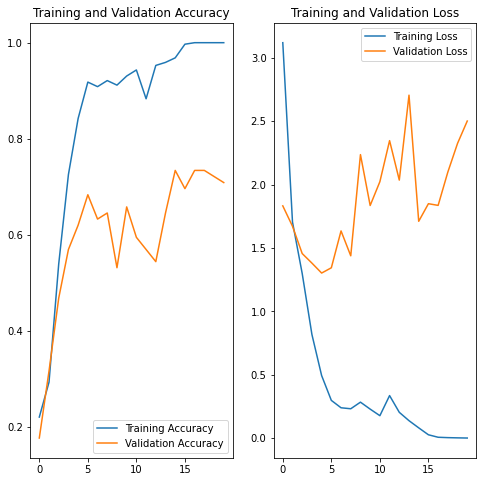

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

   8192/Unknown - 0s 0s/steptf.Tensor(
[2.1752365e-02 9.7810990e-01 6.6799896e-07 8.0344631e-07 9.4676561e-06
 1.2677349e-04], shape=(6,), dtype=float32)
This image most likely belongs to crucian carp_붕어 with a 97.81 percent confidence.
C:\Users\jamie\.keras\datasets\catfish2


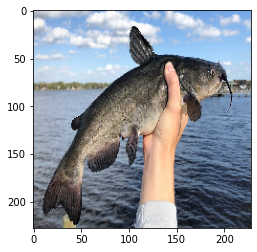

In [35]:
catfish_url = "https://farm66.staticflickr.com/65535/50185205913_2fa0c27ae7_b.jpg"
catfish_path = tf.keras.utils.get_file('catfish2', origin=catfish_url)

img = tf.keras.preprocessing.image.load_img(
    catfish_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print(catfish_path)

plt.imshow(img)
plt.show()

In [ ]:
carp_url = "https://lh3.googleusercontent.com/proxy/eMuxcYh_Qyqq-RVHFsNXt-FnETiNVc4KQIo2Fuax1vGbYpJWEeHUTun00ujtFl3rPjRR6nHuWwVmHCAAeEwNuuRQWU8h8y_ClLv9L4cNiAFWpowKhdTxjXPeTQ_aWEy06EgIYolNM70jngdT79DkMev_EjQ"
carp_path = tf.keras.utils.get_file('carp', origin=carp_url)

img = tf.keras.preprocessing.image.load_img(
    carp_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
mandarin_url = "http://fish.darakwon.co.kr/fdata/fish/contents/info/images/20110427475B.jpg"
mandarin_path = tf.keras.utils.get_file('mandarin', origin=mandarin_url)

img = tf.keras.preprocessing.image.load_img(
    mandarin_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
bass_url = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMWFhUXFRgYFxgYFxsYGhgYFxcXGBgYGBgYHSggGBolHRYVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGy0lICUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIALcBEwMBIgACEQEDEQH/xAAbAAACAgMBAAAAAAAAAAAAAAAEBQMGAAECB//EAEIQAAECAwUFBQYDBwMEAwAAAAECEQADIQQSMUFRBWFxgZETIjKhsQZCUsHR8BRikhUjQ3KC4fEzU7Ikg6LCB2PS/8QAGQEAAwEBAQAAAAAAAAAAAAAAAAEDAgQF/8QAJREAAgICAgEFAQADAAAAAAAAAAECEQMhEjFBBBMiUWEycYHR/9oADAMBAAIRAxEAPwCwTtoJwoYDnWxQwTFdMqfrHC1Wg+9HRyOaiwoty3wgpVoBTXGKc84YvBEm2zhrApg4liIjhStS0LJW0p3w+UGSVrX4kRtNMTRyu4ffrHUuzp+J4KTYkj3REolo0aCgBldkkYAmIpdqlPWnCDiiXoDEZs6D7kFCOpdtSMKxNMn0oRyiJNhlnJo6Gz0A59YewBJs/wDmiMTHzhmqQgDWAp0qX8BhMZyjiRziQBWpiJElOQUInTJIwUYaE0Cz5JXRRBGhDwit/sdLU6kKuK0FU9MhFmJ1rEbaQnFPsE2uimDZtvlHuKKg3ur8mU0Q2radqAHahYagJBTzcMCYvqFNG1KvBro51EYeJVpm1k+0UZHtTNBJJBBGDUHSoMSzV9pLTOXiSWplFwRYpaX7kutcBFe28lr9BiWAw+2ic4tLbNwkm9ICKCSBgAyv8wvnm6tLJe+pydKip6wffJB4AciYX22azJ3gcnBPpEl2VfQ1E52CcThuSMVfSJJgYMKfeMdWCSwJV4qPywHL5wRKkXi5wyjpIoGTLYRHNRQwauW5phEE9NDCGVf2jR+6T/OPRUVwxavahLSh/OPRUVWIT7OvD/JgU0dhcRmNGMNFozlHonKXiJUqMSpolCoztFU4ZO+weMgq7GQ+Qex+nsk20BJqodIGO1JOY8oNKUnxEcxGhZpJrQx3UzxQAWuUT4iOUSqmJ90qPKCJykCiUJPMQKJix/D6QgCLNMBOfMQWotnA0i1qZihoISs6AxqxHCHO6NzrGWe+Y2ZxwMvpA0yYRhLX1gbGbXYFgOF+UcIExP8AE8jHaNrLH8JUdft7WWekK0BwAtXvjoYhPaPRaTDKTtlBxR/4wQLfKV7vlAArRPn6JPODUWuZnLg2XLlHBoxSNH6QBQH25OKCIkp8JiYyqeKAp09aTkoZXcYdhRqdM0QekD9sRinyg5JzUSnjHVwfF84BC5VoToX3Ax3KmJOSjyg7sjkeojlUubkpMAURhvhMKttWPtEkszAnj9IcS0zfiTE6rOpSSCU1BHWE1aoa0ygoRj91ECWixlciYtN0zL6Zab3hZSSVvyhwdnTCiYsYoN0jO8MW3NA82xBcrsFvLS6Zi5lHKjUCWXoUgBzvZo5oRfLZeb1o7kTE2eVLRMWHSkBRJdznU419I5l7YXM/0ZRUPiJujk8EJ2VKAdKUrPxreY/OrRyZ8xNEol8EqbyZ46CZiFzFDvpuDOuPAxwXVwy37+EaXtBSWMyWUg54j6iCUKCg6S4hMYvt2xVWlJlpKQod4XsC1GcYY4xS9o7KmyVXVoKTk+B3pOCuUen7Mm3FEs9G84nty+1SULQFJOTUjEsae/JSGfh8WrR40RGoum1vZTOUD/Kr5K+sVW1WFaCygQdCGP8AeINOPZ2RcZ/y/wDoLHUt3YZ5a8o7k2dSyyQSYuGwvZ24yplVZDSMt0HCxVZthrKQSBXjGRek2SkZGORT2/0bzLYgYAQBP2gTkluENFyhmAYEm9mMUdI9F2eOLV25GaEvESdopfNtBDJMqSfdA4wZK2fIOQjNMdi+VbEqHvNB9lnShq++Jf2MjItGjsP8xh7A7m2xLUFYiFrXpGK2P/8AY0Qq2RMGE2AA2Ra3xpyjc+ake8mFszZVoIot4gFgtAxS8Ahx+MlgeME8Ij/aiBil+UBS1rRjKiX8SVU7MCAAlO1pJwN07xEwt4YkFNBkYWTUD3kpFHDnTdnC+0ISa9mQG8SC7HyLcoxPIoo1FNhNq20vtO4WN3wLFCa/d4PzhWbRNUVMSlb3igUqK3peT7qhWbvEpmpCWmMpGSqAjlrwhTtHaSXaU62wVUeeJjjeSUnosopFy2Ra5dpT3wL6fElzX8wByPl0dwVyZY7zIG8t6x5J+MmX75V3srtGdtBoT5xHMtExRe8fsf5jpjk18ibjvR6mva9m1fg8CTtuWbC6ptwUfQR5zLQs4ktx+3z8oKmbMVdBVgRR+Y+XppGXnSBQZdpe0bGou5TxStHmpIEGWa3WdQPZLEwflWFehpHmQsoBYEjgTXmIyZs0li5vYgvXq8NZvwHEvu0NoFIuyEKMxZGIcAFSUrU2bBTs4dojmyEjxY63H+RaKZJ2jaZRSe1KmwEzvCrb/usNbJ7VAlpyTL/MnvJ6YjzikckWKhsLNJxvBKs7pKfINHYkjJZPGv8Aycxuzz5cyqZqFbrw9DURKuRGwBZiDgo/Q9XHpAZsVwujunQeFXLIwdMWRQhxpEXaC6S9B1G6AY12PZSpBU2bdA/zg3sVjACOtmyymWlJocTTMl25YcoJXKOo6Q0ibBFSl5tC3atlkqTdXLSs78t75QwtaylgFVV5N/mF6pTqIxOcRzZePxR1enwcvk+hZYtlol+FIHr1hjJk5nDCCkWeMu5fdI4j06BlJORpGRuuQpGQgCDYj+Y846TZ0uxLHeRAP46eP4YPGNSZ0y9eMpL8Kx6dnhDJVgTo/No4VYAKsptxeB5loWRUMNwjiTaLuCVHiT6QDDZMxJomaXGRxESrTMymDrAabaon/STBUmYnNKH3GADBZ5pxWDEkuxzMXHWIgbpxU2jgwWbegCl7pABkyf2Sbyy+4VJMKpvtSXZKE/1Ev53YXe0drClVoAKd2nkXhTLmNm43Fx+k1EcOf1Ek6iXx47VstI9pS3ekg6d5n6gjzjcr2is58aCg/qD6OmvNop1ptwALFuGHMGFU6cScSBCxZcr2xzjFFq2t7QomHFQSMEUUHYPkDlCWdtlQ/wBMBG9//TCFstG7dEqLM56RqVXbMqzmZNUsuolR30HICkSpkPnwbqM+EF2ax0PBwcMd50+8IPsuzD3SA+GRxOTZ5RKWVLo0oisWRyAlLnrU5aDGDLNYjo9RkCzF/WLEjZZDAigYjSu7ewx1EEGxZYM3Sh/vzMQeY3xK9Z7FUMW1+lOHOGVtsKp0sIS1BRywdTYa4YRvaKgCq6zAgnc+A84n2OHJJcsMWqRTL5PrDTvYCP8AZa5QvEpJdiMG4jflEAsSiaqbhQcKiLVtH94gshgkOSdAP7YCF0uzlqihGAFQcG4hj5xvk1szxsTTdmUreNMSTyYfefGAbVYUpDqVQB2wOIDPxMXmz7NJoSBk9dPvkYTbb2SV3kpLgDJONXJLHJsQ+EOOTexOBW7LstF5piFJLEi6pyK5g48aQQsTJCiJc1QILFJN4c0lxB9g2AZSb98FShdYHBNNYO2ZsjtShSw0p6jC8R7qWypU8or7ituPQKGtgdl232gIWm6QzqAN19/w84c7AkJnKKrySmWaJBBKlD3iMkg4anhXe3ZMuQlSZaAVTMR8OQugBgwPVoSbC2SfxMoFADCYomoJdJxbeRF45XaTE8apuy+9mrJukRFKxvPSI+yHw83LwWielqsOcdRzixaSqaSQBdS1NTX6QJstTzF/zEffUxNJtAurWc3MDezcskXjmSrkqo8mjzZy5SbPax4+EIobrDcoFnKq2pEH2oMIXlGKunpGbKUcKmgUGAjIHVwMZAZthZkEfEd4IjX4QKNFK5EQYLQkhroJ4gxsTboe6PIGPSPEA/2cnVcQTLKBgT0g5NvBJDKxbEViQykq91XXCABQdnqVjMIHCNp2En41dIajZofFQ84itOzV4pWXhCoERskCnaqjv8G38c9HgCfY5wxrAUySrNxAAPt9d2YWKiKMpJYHk3zhTOtFOGdQeopDDadmdDsCRwHV4rc11KbIYnJzl6RwzxXk2dUJrgSFZVU4ZR3KrluH3zjiRLvFsvt+UOrNYg3SvOr/AEgnNLQkrI7PZScterDrDSTs81o4oeH2CYK2fYX7zsPWmuGvSHlnSAm8Bi1AxwDONOByMcc8jNpAuztk5nMhxpg2IxqqLBs/ZwvPgAUswGhOH3iIm2cljk1MNHSzk4NhrB9oUEuaBwT5LPyEc7bbNpAE+S6VAioG6ubnkfPhCG1rAArk+r72zz6mHs2aq8BgCS9KAUbjhC/aNmCSSxNHwq50Ayw8tY1GImynWsqvXkuSRUDNmANdItvsbPRMRdUwWKqSwwLhwdHoRjCbatlI74o2NRkQ1Opbe8dbIshX30EoWCO8GoS24ukhKnBxrnjerQi4bfs47MUDOl207RFPTkTFZly+6VKwBA03fKG/7XUoXJiQhTJCjUA3S7oOhcwxFllomhbC4pLEYjIvTAYQ4wbGyt2tE6gQKKGADBsq5CI5uzilPfU5fwio30OH3rFqUUG6mW2INGwP2NINtGx0KKFKJLBtASTQAaYxb230jKq9lY2RspKUlZemP+YVWDa4tFovJSBKS6JY1Djvc2TyAzi2e1AaxzymjSlAdG6uT1ih+yklky/zluG/yjc4qFL9BXJjWVYDNWqZeYjvCjihoD5nmIKTI/6i+wbsmHEkEwbZ1pQlCslY88lenKNWlDslDBn5kn0pHRji7p/5CdKFk17hA9tAIb4qdYi7BeoMaXKVHTLaOWLSabAbTIStAlDD3ju04xLYVMsjJ/QCJApY9wGI7Jmo0qfWOPLjUIV+no4Mry5G/CQRaZ3eCdQ/RvrAdtPhSKZmJUqBmk5JS3M4/KB7QoqXQYJJjnO29HabUgBjjGRXbVae8e9nGQ+JL3BQiSRgVDnBiJ0z/cV1MWhFhT/tnpEp2SDgluD/AEj0OJ4hVRLmGocwRLtc9OvnFkRssprfaCpdkOaknk0FDorMrbM9PvE8RB0r2kX7yOhaHgs0s4pSTHC9kyj7sMVAsjbqVYpUOT+kTItEtefUH5iOv2VLypyH0gDbFqRZkXjML+6m6K/23wWMl2nMkypZUu4QQzNUvlHnc5YUpkBkvQavRyczvyaCLVa5lpW6zTTIV0+UFWew403V45/dY5M2ZdItCH2cWKzXW48Kj5RYbFZWNa4FiOTkfKIrNKZFKkc9fNoaIsyqHUAg6XWNT5x58p2WSOrMguRkS3AsGPl6wwsVnPuh2YkYDGu/N4msllBVeILsGB4VYa49IZSJAStRNHwzOGGe7kTpE9voZLLlBKAc0jlVgeIoIUbS2izA1LUzDF8AMn+Ygjb1sITdDj5ltOTQks0lM0OtZSQ4SAA5YkOXDO+W6NxgbhB5HSC7Pa1FSSSSRqeDNplXhE1tmEuTQAPUtTNzl8n4QnXbDZy+YcCmNa5cPvFPb7euaXUeWAHAa4Vhy+Oyjwrj+jHam05XZqTeJUQ1EhmOIKuhcPgeMSewSxMUuTMN03XQrDA4Prmx0hGiwqXQQ4slkmS1BRCWT4gEnDjhllGsUrZOUaVFn2tZlSyntZd4HAtQsMtKtGpU0hKUgXkBwmrKCdHarVGrRwLWCkC6Ag5Xu7yJwPAiB0qYkBRL5MSeojpa+jNoMVs5IUFgFJSXvCpGrsYIsPtAFG4VOXoSRUvrgIXSgtKnKwj8pF5hqXw4NAVp2aktdXcxIJIdtXBDHdDhCfkJTiXO37Pm2izzZYuC8kir0cY05ZRS7NZ0yUBKyELl1UDkRUkah3wjJftJPsyrl9CyKl1FLjTC67esS272ls9qN2eDLIa6SM8iT8IO4RSUL/oUZbCLBaUlIkTxdvgkHCqzeAfB6xHJndioyZhdQe6W8Qcl+O6FO0bWQkC8FAHNlJY6YEDdCTb22ioIJUQuX4TjgaVzbfpujcc26fYSgnGvBdP2ih2736FN1aNi3IPxfpUB5iANk7YM6SiYAO8KjRQLK8wYL/FK0Eda2cL0EFYZ2pCxKml3sHr84kt01RQQzUam8t84XW60i6JeeHLOOT1b6R6HoY/GTJbPNF0uaqr6fKAZ9uIvhBqruYA+uFdIwSTNLJe6MT95xJI2OUeEZu+ZOsTxYXLZvP6iMfj2T2GyyUISlSQtQxURiSXPrGR0LKvSNR3cY/R5blL7G4TO3Ab44AnD3kxNMIapI3kgD1hfOtMsGquYWr5JhGg15md3mRG1LDd4DljAHayiaKCv+58qQLtBdLypqUp4sOD1fhAA5l3RUAni7esSmcwcsIoy/aVQcIY08RBHQOPPpFc2htGbNUSuYpXE4csBEXminS2VWOVW9Ho21vamTKSSCFnAAHPR/Vo8/tVqmWiYZkwudBkNBAipbsTg4EMbHILi6+NG6f2iGXNa0OMCezgYD7x6mkNbFIUSKZ1d2qkF/M+Ubs2yyal2NemGOGOJix7PslHGLaA4DG8S3P7PC3fRZI42fs4MxwOD9G1Jr6Q8s9mAAGQTgasKjAaanXdEVls9SaCleNHc4n70ENU2fAjAE7veOKvv/wAoaxNjsHTZmG9jnVQpQnn6QVLFXCuQDYHfvB6kR3+G7oAwfllVzz9I4Io5yGZITRnYNXOuWcWjiMtim2WN1EtkAzknACp+8NYSWaemWooLUKmcfEb1H4xb1rpU+lOAyHirwxiie0U9KZwYglWT1pmPKN+3RbDNRkL9tzCqaVHPDHCgfCAzLISVs7VPDODdu2XtZN4FlJLiv2+EAbN2mhakSkpUZi+6E6lsKO4LecY9pMu2k7boay7aAgKQApuTjNof2PaKVAakZhiHrl674p2zErY0YObuA7u9j5PDnZcpF8JIvKfPADVtfumeuSxrZHJFZKaGE+aJV5SDdc4E92orQNXe0SWH2hJcEEZYkg8AhILQnmLE61IIDSwWSMKA1VzJPKLR2SEh25xfElNWck5OOjSLSk+FJJ1KWH6Q5Ud5MdKlgpJreOuP0A4QLO2mhORPAR57tb2ztQN8S1SkBQYKl6HBalg1IHugYxfhFE3kbL0vYUkpZQvd4qqcydRU8zGHZ0oulkUoe7UfMQr2ft9M1CV3WOBFaHiWyY11g0bUTo3JhFKRi2DzfZpDuiY258PX0hfafYZUzGfd/pvfMQ4NqkKLqLH8qiPQxLZlyUlxOXwUtRHIGMvHF+DXuP7J9mbIlyZSJSCWSGc1JLuSd5JJgg2fQmI5c1Nbs0cyPpEvbv8ACeCv7RRGCNcpwQ6eYMIZ2yzMmupfdArdB6CLGlZJ8IbV3jZTm0ZljjLs3DLKCpMCkFCAEJSpgPgPmdY7VNwHer+UxKoqyERkq0MbWibdnJI1V0P0jUbY6qjIYhAi0zWql+JI8hEgttGXKfm4PKGZSBi/JC/q0aNqkDGUs8EH5mJGhFtXaUmXLJEjvmiRUB9TuGkVRM0rN5aiT0A4buEXPb8iXaEgS0LSpLkJueJ8ndhFItCFIUU4EUO7dxjj9Q5XXg6cNf7Clhh/b7MKVrYsczjB3aBvvqfpAU+W441+98Qxquy8/kqDbKHLYl4uGxLECkUqfUHofT5U/YFoSCAqpdo9GlWyUiUG8Sh5nNRyH0pGZxcpcScdKwrs0SwSojjiMf8AyMcHaz/6cslxizAv+ZQbIYaRBY5kolyFTFalLjkMAPOGapaVCqBzDR14/TKK2SeX6ENq9opsqaELKXIBpU1OD1r3RThDay+0AIBf5nQ+ItmrrurTJ1nSqYt8XJ+g9POC02VKdN8c0stPSO14VS2egWXbgUz3csSOeJAq56CN2zbASLzgmjlJBxGRwB4RRZCBeDDBz5AAdSIcIs94AqSSnGhxy6U5+uoTlN0kZljhCPKTMt+0bRNP7khCXqpn4kXvEft46smzUBKg98r8alh1r33nBAGTYQSmWn3b43P8njq81GUeKSfnHfGCRwyyN9aFQ9nEP31zFpwCSsgDhdAL843J9jrMElJSSo1vlRvAjBiGblDaXOGTnqG5RKmY+h5w1CK8Cc5PtlfVYbh4a1rrEiZISHdlKDVpQ57yfnuhxMsrl3Fct+sSCWfeY6YejRJ4FKVs0srSpAWz7APEeAp1MFKlEfERu/zEomj4hTFj/mIlLBLX6/eoi0YKKpE3KyKYUCqn5h4Sbfs0idZ5qAvvFBugj3gHT5gQ9VKJwOED2qx9xRUzBJPQQxFC9hSlSVpUDgkjEP4kqyGQR/kxZDLSMEjy+zFb/wDjixX1LejS0nBsVUfuh8DryzvK9lqy+UJdAxSmzJejA9ImRYgcQkth/aC/2avT0jj9lqeoPX5PDAz8Ck68MR0iQWNs24RtFhXqwiQWUjEn75wxEfYtgtucaTLmO4nU+Fw3o/nEt1IxI++MQWnaNnlsFzpSScLxCfUwwJVTJ2sQzJ9pdkhLakv5NBSJyThcUN0YLSjNLcDDEBLmWl8TySn5xkFftmR/uD9QjUABAnnSnExOJxxKSd7iEalrwvP/ACpKRy1jqWmd8UwHRj84wbHabWGwbm/p9IAt2yLPNLrR3tQ6Tz1iJM2YaPUZNU+nWCJalEO4PGg5Bqwmk+wTaE9s9kJC0gIUtOpe853j/EUnbmz12eYUKwfunJQyUPukelKsQWRiG0dvRoRe2+zwuRecAy6h8SDRXyPKIzxKtFIZGnsocuV3g0X/ANiZFFLVVmSl9cVFuF3zjz6RPrXJ/KPTNnzDZ5SEKa81RfFVK7xF3HPBsonig3K34K5ZrjoeKmEhhdA3fYEQfgwrGY25wOsDC3lgSkgHz5aconFuDUIfe3ywjrOYSbTsPZzCpPeSWLiopiCdc4XzLUR5+sWW1bTTgpBIat5Bu5Uc/wB8IQTbq1XUyV8XYHheBvco48np7do6sfqK1IO2Im8LynYnEAnwuWpvPlD5VoKWCQ4391IHQwjs1onoSEJ7iQKC656Au+9oIROV704gnVIHkC/WL4sagiOXK5sZlaV4pI4HHnSOU3A10KB5sOJvekAfiSzdoSD+Qn1MSoSFBiVj/t/2IipIZqURmn9JJ81RtCGxYjgR6kwILqQ3f/QB/wCsRzCcirmAR0cQAGGSk1SkE8cObUjaUaJ4m8fpACZhA11YKGHPCN9oo966f6nSOpBgALUkGhI5q+oiMS0JDBIGjHzgOZPmKPhQk6kpUNNQYEte05iT3ZJmgfB2fPFbjpBYDVMpy6X4gjpnAXtFMUmzTlA4SlvvdJAy1MKk+1qbzTLLORxSkkcniD2v2vIXYl9msFRUhLEBKh3goukjRJhKS8A0Df8AxyhKUzlMW/dpcNim8qoDH3x9BFyXaD/kGhywFeoir+w6kpsxN4kqmKJCQFUASkP4iPDrDC1bRdwmVMWx9xSOLlK1A9RAnoBwm2JNL9Xwo/8Ayjc2eUhyoNvyqMSDSK9L9o5aVBM2VNlUckgFNPi7JZbmIPk7ZkTKpmy1fy1PQOoHjDTBoM/FuCRdWdxBI5Axozzne/Sab+ECLt0vFK+9kCbj7u8z9YAt+2FoBKpcxQBwRcmEcQKt9YdhQyVbU1KlYB/AzDe53aRku1yzVlNqUgjk2MJLL7RyF+GYgDN3SXz7pA+cZa9sywHRMkTFM4SJiAT+os8KwosYmyzmPTqMokQzOA/Aj5xUZO35S03rypShVloN3i6KNvJaDrHt6WpwlaScXBSun9Jcc4akhNMsF8fAOiYyFitq/nT+k/8A7EZGtGQpe0e+zpSlnDqZe/upTgKZ5xirevG6pSf5ConkFU6RKbQlOMuaOEsn/iCwjX4iUSzKKv5Jg87tIwUO5docPeqMihQ9YxNoSHF+6Tg949A4rENutqJfjmykaOpiORNTyhdYp65ymE6RPAxIN1QBzuXSRzNYV7oKGi5004FKhl7v1ir+1FrKJREyWHPhdSlV3BgA3GH86QpLkTlADModKf6gKc4oPtVahMUCLQmdVqSylgMCVEd7lGMkqRqKtiaSgzFhIAdRYYCpj0nYklclNJSlKYOozEFtySVUG6PPdipJtEq6AT2iaHDGPWpSQn320ozcRujOLY5gs6wCb/qk1Fe84bfQJEdSky5CLsiSK6B66m4k9Wie0AKNDe1eoPljC60ITe8Bf8l0jjkvzipMnKj/ABFAqrkR0QCW4+kSptqRRroJp4B0FCYAkTwC67wHBSnbimn6oLlbWlqUyZcw1yYDqtQeCwMTNSokAau6VJbQYYneYFWtfuy1Al2TcTgDiZgWQPukMhNUSL37vFheCln18oh/DE1BWGwdSl1fBQSWu7iYAAZa5pU1HGI7QluN1H3rG1WplMZYG/vkcXKPnHNo2Sqv72ZdxupVdqcbznvaAkPC2fZ5IUUzZSySHbuKw+MCY6vSFsBpOt8xgpFxSc7q0nyIESSdrqAF5g9PCVBzhhXyiuWuyyBhKUqgIIQhISDkUqWCo0xDR2mzLYAy0ygR47qu0rgyLykHrC5MKLJMt0xRISkhIzBN56O4SA1X5c4WWlRxVOmAa33TwvLdJ6xzI2ZLUQQgZe+oAMKkEEsSX+FmDA4xq0bNdYTLWq9Si1pUSGqUFKgoAUJCql6EQ9gLppQAVXlkkEOq6oClT3XGFO78W6E823F+/PKhkGQejkgcyOEWZOyU4rKkeG6lXeFcCwIN494kKv1wdoXWzYgR/vKnE3r0tILA07ylXU7qXThQRhpmlQkG27QG/wCpWHyJJAG9ISRXdAkyYtS0rUSVE3swQE11HGkMJlkTKBKZbkP3pk6W+n+kivJ+cQizrWkM1+YaBwkXU+NRvHByANTe0jMb8jlXQGiyzCXDhRLgl0418WHnHdpn2hHdVOXTSfe6AKduUT2iTODIvyl/lvSVU3OXIjcjZk27WXLISHUL6QrjeBbP+0LYwUW6aRW0L/lK1kc/sxCL62AEtROV2WDwqAYMtOzghlTUzZQb4QtJfAiYFUfgYEXYCReQUqTV2WCoDVSaKA33WhbNKglU6ZJPflXFAXQpCrhD5Ol0nOjREjai0BIlzFMkMEzEpWANElvkIEsi5YJvpvC6oBjgpmB4QMYVjoaWvbi1s4CSM0EgvvGDO2XOBFbTmkEFZIOIUyvUQIY1BbGkjsMcSx/lp5YdIztSwS7gFwDUPqxjgRtYYkAvvD/MAwhhcraK0gAYD80weSVgDkIyBIyCxHsf7bQcG845XawqoPSkIEyDwjrsVj+0dHJkKIdvWJZClIXM1KLyiDXIOw4RVVeY8ouImTBrA9rsSZlVID/EKHyx5xKUL2jcZV2VhVqXrXW6L362vecQLUTU+cP17CS4ZShuLE8jSALXsq7UTUscL1H3XsH3UjHF+TVoj2HtAyJyZgehqzOU5gXqfeIj1i52iQSCDoQEkcw4PIkR5BJlioIB54cNYfbI2zOkpYEKQKXVVA3Av3eEbhkUdMUo30XKZs6a7pmKAwYJSpvkTxBgmRaSTdVKWB8SikCnAkjpCSx7VRNFb8tWgUsofpdHSGqZ85NAlKxvUUn/AIl/KLJp9E2g4IdPhUg/zCo3FKm6xymSh3CVE5ua9Xf1gRVpUMUT070JEweSSfKJVTJqe8mbLIOS0ELr/L80w7QUG3EkMWIfApzHKIp1mA8IFMgpj0qOsQJtawO+UAnwk1B4uEEecEpUos3Zl8bqnbkSx8oYAKwvAiYHPvJlzA2jINBvZ98SWmRTvBRpS5RxuBNCzGClSSxA86A/peOZqiKFCScAEqUfVLHyhCoSKTKUEgqXdDn96FPhVwpNeLmAZkuWMJhOd1MwhjowQVK5AmLOuUS11Kka0WodEqBjUtRAdfn2gHO8SfJoVDEaEFSQpaylBoSQsZGhVOSkhL4d2N2Ww2dF5QIIVRQQkKcAVolJUsFyM8+TYlzdZLt4jgRmK0z4xzMnFAACbzUASxZtbxaCgAVFK3WlE8FmcrIOVAASqUTTJJpWALSEIT3pU1SiW/eLUUpFCKuzYVJSrrV4pKifEbrYB/VJ+XlC7b1mUpB7OepFXJHfJZwwvKDHgqkDARbRtwCDKlIR+8ors0pUo/llhNQSxoXJDl2iTZE6VLDrs6lrUmrplKCAA11Cb3aMHIJapJeAdmlcmcVKWPCReUQDU95iiYWJo5Jq0PbJtSQkkibLvHF5lCdWLwrCvJNK2zIIYWYJKdUXEj+oC5TeWiOeszWMif2JfFMtE2rPgFKKdasK1gibtxLAidKKsHcE72fdlnHFltl4llKVvdaRTHwt/kQxk8vYgWkKVNK1nGbLAThTI3eRBG7OF1r9h0qVfROKDQ0SGDZoIqk544wxUGrQFJoVJ7QAnEgXnfCr4COLQbQruialFW7qQSN7LBDfbw6i+0K2BbU9lZVy+WKkjvFQUb4GJUR33/MDyMJ9oeybg3UKQq8yHmBfaA51IDD+ksDQ4QQJVsv0mBQBqVKDn+hNCOmGIeG9ltBD35jG85IlhIUWarrUTl0jNRfgdtFNtnslNSxBQHBZJWHcAU/M9atRq0hTa7DdUUIC1lI75AJAL1Zh4d/mY9P7VwFdqQmrEJSL2OJNC24Co5QpmbGs9o/dmZOcOasHUT3lq7tTloMgITxLwaWT7POgA2Jfg4P0+8I2Zhpm1A4B9cecXtfsZZE0XPWFcUgngLh3QvsvsaCla1zSgC9dHZr/AKaqSCr+lMT9uRr3IlZE1P8Atp/Uuu/xRqH8v2LnkAgiv5Jo8igGMhcZfQ+SPRbiT/D6ER0izo+FoyMjoIizb9jU15M0SpaQ6iE3lHlpFVmW2UosqdaFAZoupB3sSPONRkRy6KQ2YiZYgO9+JXmASkB9aH5wut82Sr/TlFO9SySeIJI841GRG7KUBCrR6N7IrWqSyDKN1kl5d0ijsSmisdOcZGRXF/RifRYZUtaQL3Z8ksOVflBUxQCXwA0D+sZGR0kRWra0rOattLiW6FMR/ilqdUpIUnVV4ekwekZGRGMnJlHFJAv7VSB+8koTvu/Qkx0vakuWQogOaeOa3RiPKMjIwpuzTiqsPke0FmWmqxvF1ZHmkRENpWMGk0p3BKm/4RkZFVKydE6p9nWDcAVyUOuEKp1slJIaVKN4P3wvlSojIyHISDBPIDoloAw7iAAOLqB6Qmt22JQftCoF/wCGkpPBysiMjInklRuCsBl7VsynDWpzX/Vb0UI1L2xIFEzLYneVJX5qUS0ZGRhTdD47ORthFQu2TWIwVJSet2FNn2l2c4qStNwmqjLpXHuhvKMjIak2JqixzfaaQB3ZyFcLOsdCVPAaduyQyiXS5x7VJHAhavSMjI05uxVo7G3bLfAE2in8RmnHhLfziZQllihMwj8yhdbd3jv914yMhqVjogRPkFR7z/lvzsOJFeENL4mgJl1LfCHoNSA8ZGRpdCa2Qz5CkhN5Rp4XBJ5ETTlrEljnXgpSFXmoQSphyUMeZjIyCP8AVCf82dyJK1OFBATwB6hjEq1JSw7UlAyBWnokJI5OI3GRt6RlbZyibIIcXzvf6peNxkZAgZ//2Q=="
bass_path = tf.keras.utils.get_file('bass', origin=bass_url)

img = tf.keras.preprocessing.image.load_img(
    bass_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
carp_url = "https://i.ytimg.com/vi/KlKg1LRnsMo/maxresdefault.jpg"
carp_path = tf.keras.utils.get_file('carp', origin=carp_url)

img = tf.keras.preprocessing.image.load_img(
    carp_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)